<a href="https://colab.research.google.com/github/bxnkz/pj_AI/blob/main/almost_any_multiclass_image_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit for the source code


In [ ]:
# https://www.kaggle.com/code/anindyajana/almost-any-multiclass-image-classification-cnn

# Import kaggle data source

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fruit-and-vegetable-image-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F952827%2F3173719%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240330%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240330T132341Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D71123bd097b693193f61acb82ce3e9439da4bf9f1da82b041d11e644b34243240557392a63e12a5053ca6b0338721228be5990cf92228412f2234fe4e99f841ddfa182e34474ff5683845f4c1abdd6126d698f222b799a79b7c3b088ef6281f6829c9118ed8719b05122f3f4e890465107e9a88be0cd2b787c02ae2009b1ebaa3b6f0ffcf2c0f1b2b8c9635b27d46edd57b90a41b7bf1473d37c5e9cfdb4bc4742cdf1d7153ab6775e03b8a1944cf2536ca64d9740a8f76aad80c36370429eb7723cd09ccb816553179f6ec7263112a31e17317733529d45c09cba809907f0e29483ebe64038a627f9b48c1791788e3618ed189b1b7887874672aff65c719f65'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2130757290 bytes downloaded
Downloaded and uncompressed: fruit-and-vegetable-image-recognition
Data source import complete.


In [ ]:
import os
import numpy as np

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
import tensorflow.keras.layers as tensor

import keras
from keras.utils import image_dataset_from_directory
from tqdm.notebook import tqdm

print(tf.__version__)
#this notebook works on both keras v2 and v3
print(keras.__version__)

2.15.0
2.15.0


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Loading the Data
This dataset contains three folders:

train (100 images each)

test (10 images each)

validation (10 images each)

each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present

Using keras image_dataset_from_directory function to load data directly to model and get the labels from the folder name.

If a validation folder is not present, you can use validation split from the train_generator.

In [ ]:
image_directory="/kaggle/input/fruit-and-vegetable-image-recognition/"#specify the image directory
image_dimension=256 #global image dimension

train_generator=keras.utils.image_dataset_from_directory(
    image_directory+"train/",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(image_dimension,image_dimension),
    shuffle=True,
    seed=None,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
validation_generator=keras.utils.image_dataset_from_directory(
    image_directory+"validation/",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(image_dimension,image_dimension),
    shuffle=True,
    seed=None,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


## Generating labels
This labels are  used in predicting the accuracy of test images

In [ ]:
output_parameter=len(train_generator.class_names)
lst=train_generator.class_names
res_dict = {}
for i in range(0,output_parameter):
   res_dict[i] = lst[i]
print(res_dict)

{0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


## Visualise the images

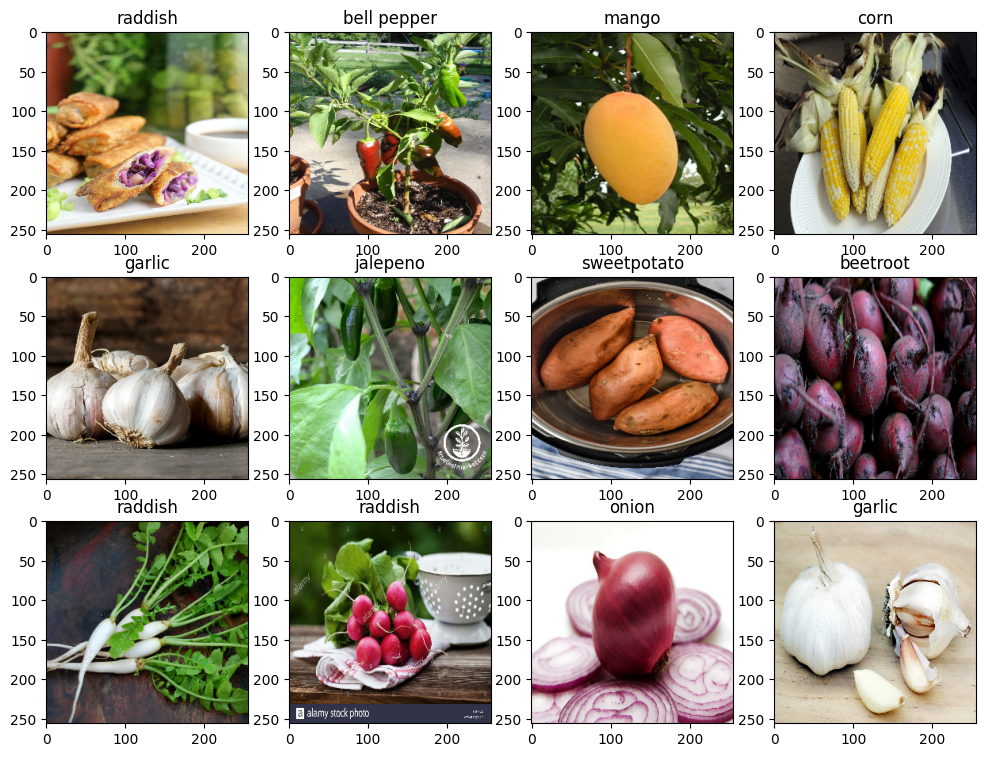

In [ ]:
plt.figure(figsize=(12, 9))
for images, labels in train_generator.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(res_dict[np.argmax(labels[i], axis=-1)])

# Building a simple CNN model

In [ ]:
inp=tensor.Input(shape=(image_dimension,image_dimension,3))
#layer 1
conv1=tensor.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(inp)
pool1=tensor.MaxPool2D(pool_size=(4,4))(conv1)
norm1=tensor.BatchNormalization(axis=-1)(pool1)
drop1=tensor.Dropout(rate=0.2)(norm1)
#layer 2
conv2=tensor.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(drop1)
pool2=tensor.MaxPool2D(pool_size=(2,2))(conv2)
norm2=tensor.BatchNormalization(axis=-1)(pool2)
drop2=tensor.Dropout(rate=0.2)(norm2)

flat=tensor.Flatten()(drop2)

hidden1=tensor.Dense(256,activation="relu")(flat)#512 for better
norm3=tensor.BatchNormalization(axis=-1)(hidden1)
drop3=tensor.Dropout(rate=0.2)(norm3)

hidden2=tensor.Dense(128,activation="relu")(drop3)#256 for better
norm4=tensor.BatchNormalization(axis=-1)(hidden2)
drop4=tensor.Dropout(rate=0.2)(norm4)

out=tensor.Dense(output_parameter,activation="sigmoid")(drop4)

## compile the model
Then, we can compile it with some parameters such as:

1.Optimizer:adam = RMSProp + Momentum.

Momentum = takes into account past gradient to have a better update.
RMSProp = exponentially weighted average of the squares of past gradients.

Adam is an adaptive deep neural network training optimizer that has been used in most cases.

2.Loss function: we use categorical crossentropy for classification, each images belongs to one class only.

3.Metrics:we use the 'categorical_accuracy' metrics.This calculates how often predictions match one-hot labels.

In [ ]:
model = keras.Model(inputs = inp , outputs = out)
model.compile(optimizer = "adam",loss="categorical_crossentropy",metrics = ['categorical_accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248  

## Train / fit the data to the model
Fit the model to the data from the train_generator.
The neural network will learn by itself the pattern in order to distinguish each category.

In [ ]:
training=model.fit(train_generator,batch_size=8,epochs =20,verbose=1,validation_data=validation_generator,validation_steps=10)

Epoch 1/20
98/98 [==============================] - 304s 3s/step - loss: 3.1503 - categorical_accuracy: 0.1621 - val_loss: 3.4780 - val_categorical_accuracy: 0.2188
Epoch 2/20
98/98 [==============================] - 296s 3s/step - loss: 2.2186 - categorical_accuracy: 0.3551 - val_loss: 1.5107 - val_categorical_accuracy: 0.6281
Epoch 3/20
42/98 [===========>..................] - ETA: 2:25 - loss: 1.7400 - categorical_accuracy: 0.5060

KeyboardInterrupt: 

## Ploting accuracy score

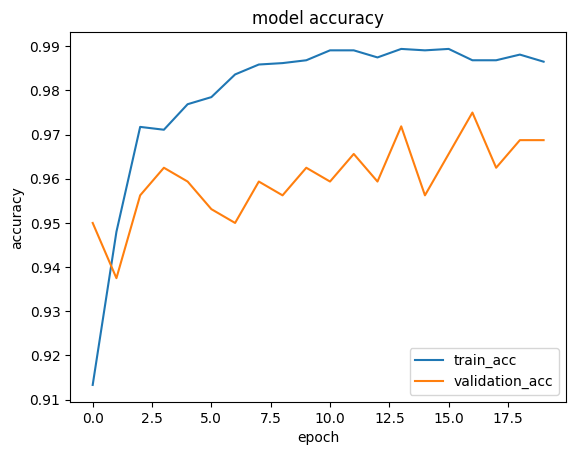

In [ ]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.legend(['train_acc', 'validation_acc'])
plt.show()

# prediction
Creating a custom function to predict accuracy and analyze probability.

In [ ]:
def predict(img_rel_path,show_details,show_indiv_probability):#prediction function
    # Import Image from the path with size of image dimension
    img = image.load_img(img_rel_path, target_size=(image_dimension, image_dimension))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])
    predicted_class = res_dict[np.argmax(p[0], axis=-1)]

    if show_details:
        #Plotting the Loaded Image
        plt.figure(figsize=(4,4))
        plt.title("Loaded Image")
        plt.axis('off')
        plt.imshow(img.squeeze())
        plt.show()

        print("Predicted label:", predicted_class,predicted_clas)
    if show_indiv_probability:
        print("Maximum Probability: ", np.max(p[0], axis=-1),"\n")
        classes=[]
        prob=[]
        print("\n--------------------------------Individual Probability---------------------------------------\n")

        for i,j in enumerate (p[0],0):
            print(res_dict[i].upper(),':',round(j*100,2),'%', end =" ")
            classes.append(res_dict[i])
            prob.append(round(j*100,2))

        def plot_bar_x():

            index = np.arange(len(classes))
            plt.figure(figsize=(10,5))
            plt.bar(index, prob)
            plt.xlabel('Labels', fontsize=12)
            plt.ylabel('Probability', fontsize=12)
            plt.xticks(index, classes, fontsize=12, rotation=90)
            plt.title('Probability for loaded image')

            plt.show()
        plot_bar_x()

    return predicted_class

## prediction of a single image

1/1 [==============================] - 0s 240ms/step


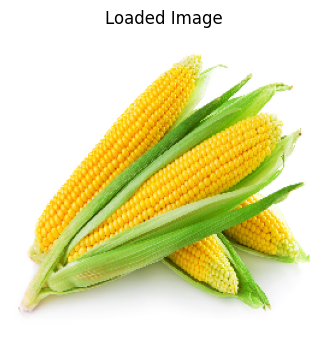

Predicted label: corn
Maximum Probability:  0.98421705 


--------------------------------Individual Probability---------------------------------------

APPLE : 35.76 % BANANA : 85.15 % BEETROOT : 16.89 % BELL PEPPER : 60.09 % CABBAGE : 81.44 % CAPSICUM : 88.83 % CARROT : 15.35 % CAULIFLOWER : 29.71 % CHILLI PEPPER : 36.78 % CORN : 98.42 % CUCUMBER : 12.31 % EGGPLANT : 7.85 % GARLIC : 14.99 % GINGER : 14.4 % GRAPES : 68.84 % JALEPENO : 54.35 % KIWI : 76.48 % LEMON : 96.64 % LETTUCE : 85.68 % MANGO : 50.65 % ONION : 19.34 % ORANGE : 57.42 % PAPRIKA : 55.02 % PEAR : 63.52 % PEAS : 91.87 % PINEAPPLE : 27.82 % POMEGRANATE : 15.35 % POTATO : 43.44 % RADDISH : 14.31 % SOY BEANS : 34.93 % SPINACH : 86.53 % SWEETCORN : 88.63 % SWEETPOTATO : 8.74 % TOMATO : 13.45 % TURNIP : 5.8 % WATERMELON : 46.25 % 

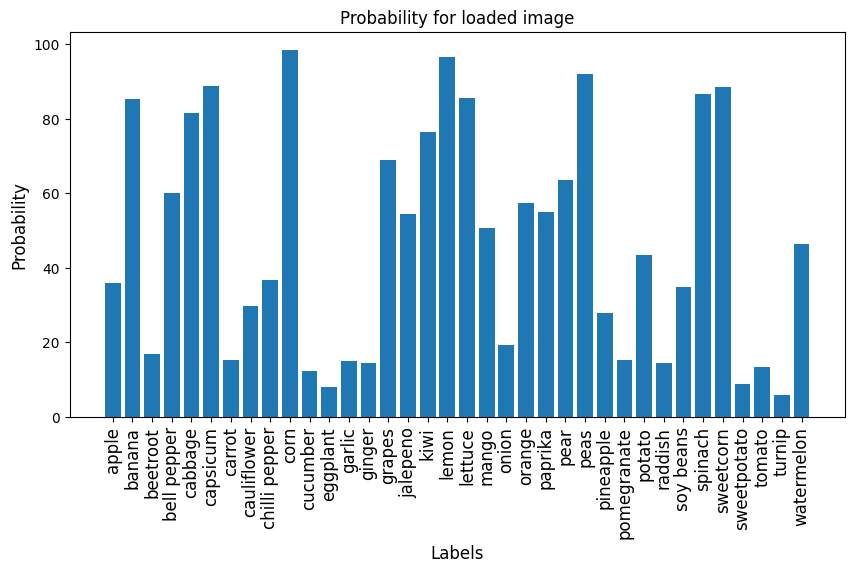

'corn'

In [ ]:
predict(image_directory+"train/corn/Image_9.jpg",True,True)

1/1 [==============================] - 0s 48ms/step


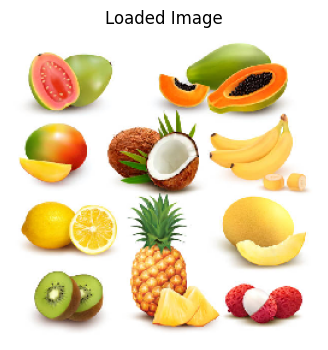

Predicted label: banana banana
Maximum Probability:  0.9129571 


--------------------------------Individual Probability---------------------------------------

APPLE : 21.22 % BANANA : 91.3 % BEETROOT : 41.86 % BELL PEPPER : 45.32 % CABBAGE : 10.44 % CAPSICUM : 68.49 % CARROT : 74.05 % CAULIFLOWER : 67.37 % CHILLI PEPPER : 46.21 % CORN : 60.89 % CUCUMBER : 13.8 % EGGPLANT : 44.35 % GARLIC : 67.05 % GINGER : 62.78 % GRAPES : 39.75 % JALEPENO : 60.53 % KIWI : 50.73 % LEMON : 83.09 % LETTUCE : 14.81 % MANGO : 75.85 % ONION : 52.66 % ORANGE : 83.12 % PAPRIKA : 39.27 % PEAR : 66.05 % PEAS : 56.46 % PINEAPPLE : 90.46 % POMEGRANATE : 53.29 % POTATO : 63.84 % RADDISH : 21.67 % SOY BEANS : 87.48 % SPINACH : 21.82 % SWEETCORN : 77.45 % SWEETPOTATO : 29.81 % TOMATO : 30.15 % TURNIP : 61.05 % WATERMELON : 17.43 % 

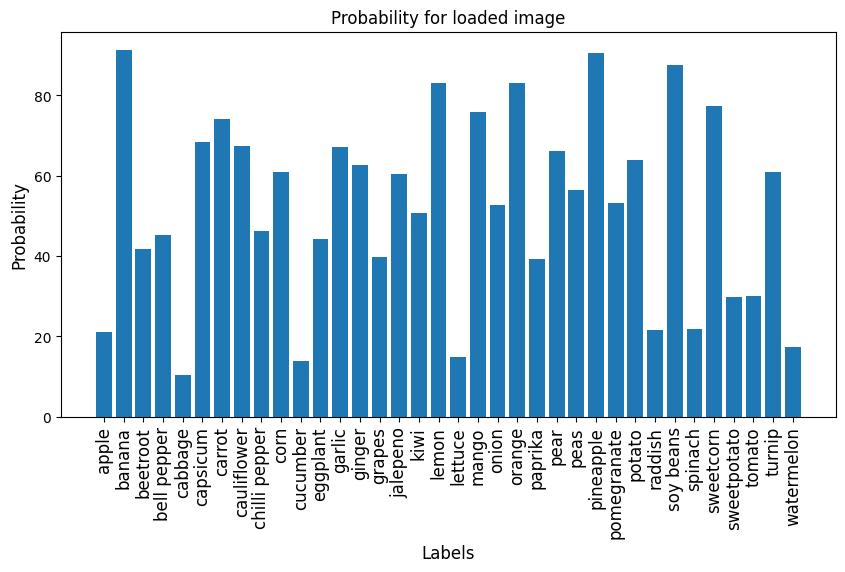

'banana'

In [ ]:
predict("/content/fruits.jpg",True,True)

## Viewing wrong predictions made on test dataset
wrong predictions may be due to improper images or using less accurate models.

  0%|          | 0/36 [00:00<?, ?it/s]

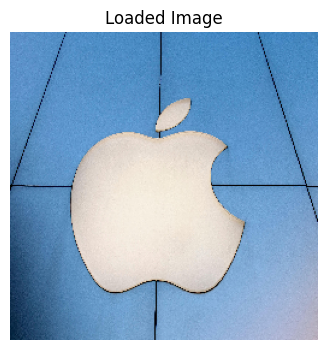

Predicted label: onion
True label: apple


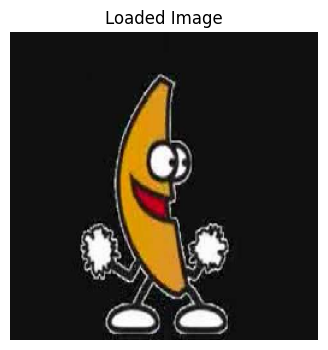

Predicted label: garlic
True label: banana


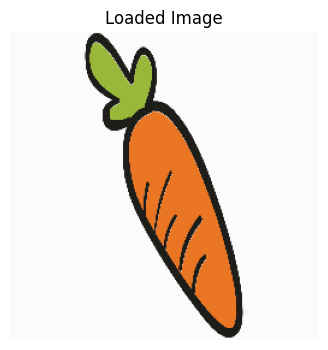

Predicted label: tomato
True label: carrot


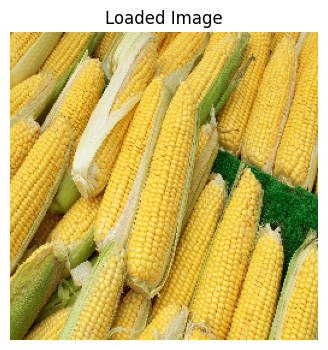

Predicted label: corn
True label: sweetcorn


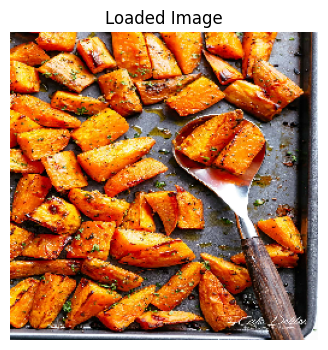

Predicted label: chilli pepper
True label: sweetpotato


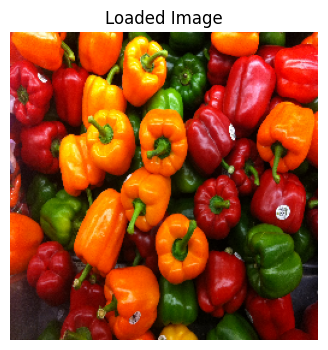

Predicted label: capsicum
True label: bell pepper


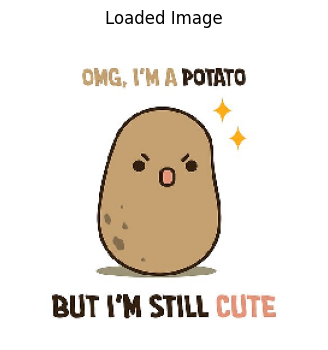

Predicted label: tomato
True label: potato


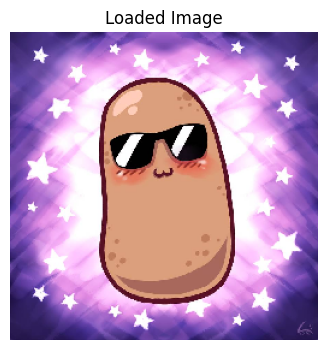

Predicted label: onion
True label: potato


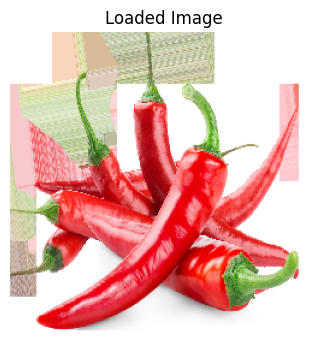

Predicted label: pomegranate
True label: chilli pepper


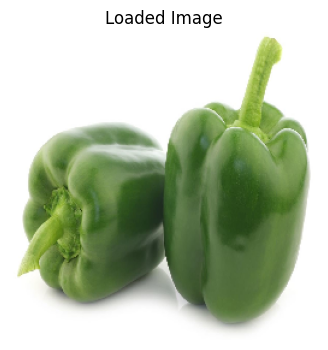

Predicted label: bell pepper
True label: capsicum


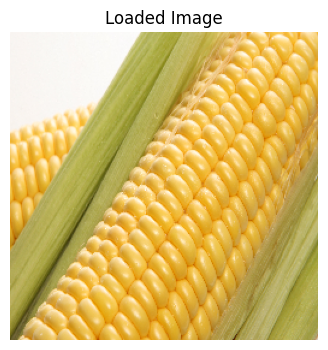

Predicted label: sweetcorn
True label: corn


In [ ]:
image_dir = image_directory+"test/"
tf.keras.utils.disable_interactive_logging()

for categories in tqdm(os.listdir(image_dir)):
    img_list = os.listdir(image_dir+categories)
    for i,img_name in enumerate(img_list):

        if predict(image_dir + categories+"/" + img_name,False,False)!=categories:
            predict(image_dir + categories+"/" + img_name,True,False)
            print("True label: "+categories)

## predicting and calculating accuracy of all test images

In [ ]:
image_dir = image_directory+"test/"
tf.keras.utils.enable_interactive_logging()
total_images=total_pred_c=0

for categories in os.listdir(image_dir):
    img_list = os.listdir(image_dir+categories)
    individual_pred_c=0
    for i,img_name in enumerate(tqdm(img_list)):
        total_images+=1
        if predict(image_dir + categories+"/" + img_name,False,False)==categories:
            individual_pred_c+=1
            total_pred_c+=1

    print("Accuracy of detecting "+categories+" is :"+str(individual_pred_c/len(img_list)))
print("\n Accuracy of detecting all test images is :"+str(total_pred_c/total_images))

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step
Accuracy of detecting pear is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
Accuracy of detecting beetroot is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
Accuracy of detecting kiwi is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
Accuracy of detecting soy beans is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step
Accuracy of detecting grapes is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
Accuracy of detecting apple is :0.9


  0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step
Accuracy of detecting banana is :0.8888888888888888


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 108ms/step
Accuracy of detecting peas is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step
Accuracy of detecting raddish is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 107ms/step
Accuracy of detecting mango is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
Accuracy of detecting ginger is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step
Accuracy of detecting carrot is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
Accuracy of detecting cucumber is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
Accuracy of detecting cauliflower is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step
Accuracy of detecting watermelon is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
Accuracy of detecting sweetcorn is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step
Accuracy of detecting paprika is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step
Accuracy of detecting garlic is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
Accuracy of detecting onion is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
Accuracy of detecting cabbage is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
Accuracy of detecting spinach is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step
Accuracy of detecting lettuce is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
Accuracy of detecting pomegranate is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
Accuracy of detecting sweetpotato is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step
Accuracy of detecting bell pepper is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step
Accuracy of detecting potato is :0.8


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
Accuracy of detecting chilli pepper is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
Accuracy of detecting jalepeno is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step
Accuracy of detecting capsicum is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
Accuracy of detecting tomato is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step
Accuracy of detecting orange is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step
Accuracy of detecting corn is :0.9


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
Accuracy of detecting lemon is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step
Accuracy of detecting turnip is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
Accuracy of detecting eggplant is :1.0


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
Accuracy of detecting pineapple is :1.0

 Accuracy of detecting all test images is :0.9693593314763231


## So the Accuracy of detecting all test images is :0.9637883008356546